<a href="https://colab.research.google.com/github/torrhen/pytorch/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Import image train and test image folders

In [2]:
import requests # HTTP requests
import zipfile # file extracting
from pathlib import Path # file management

image_path = Path("data/pizza_steak_sushi")

if image_path.is_dir():
  print(f"Image path already exists at {image_path}")
else:
  # create local image folder
  image_path.mkdir(parents=True, exist_ok=True)
  # download image file from github repository
  with open(image_path / ".zip", "wb") as f:
    print("Downloading .zip file")
    response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(response.content)

  # extract images from downloaded .zip file
  with zipfile.ZipFile(image_path / ".zip", "r") as z:
    print("Extracting .zip file")
    z.extractall(image_path)


Extracting .zip file


In [3]:
train_dir = image_path / "train"
test_dir = image_path / "test"

#### Visualize a random image

Image class: steak
Image width: 512
Image height: 384


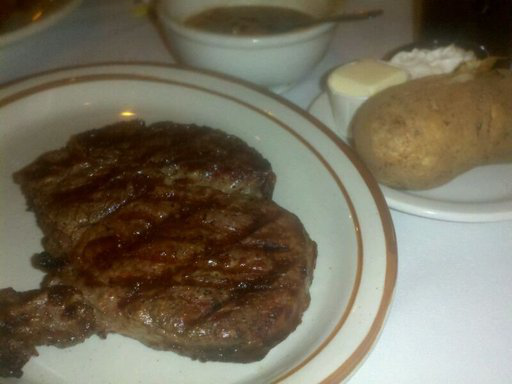

In [4]:
import random
from PIL import Image # Python Image Library

# set seed
random.seed(42)

# get all jpg images within the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# get path to random jpg img from the list
rand_image_path = random.choice(image_path_list)

# get the class label from the stem of the image file path
image_cls = rand_image_path.parent.stem

# open image using PIL
img = Image.open(rand_image_path)
print(f"Image class: {image_cls}")
print(f"Image width: {img.width}")
print(f"Image height: {img.height}")
img

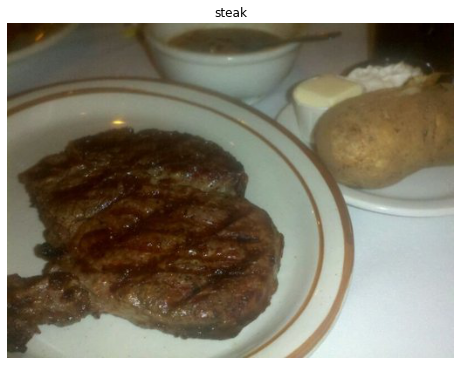

In [5]:
# visual image with matplotlib instead of PIL
import matplotlib.pyplot as plt
import numpy as np

# convert PIL image to numpy arrange before using matplotlib
img_np = np.asarray(img)

plt.figure(figsize=(8,8))
plt.imshow(img_np)
plt.title(image_cls)
plt.axis(False)
plt.show()

#### Transform the image dataset and create data loaders

In [6]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [7]:
# combine multiple transforms into a single transform using transform.compose()

data_transform = transforms.Compose(
    [transforms.Resize(size=(64, 64)), # resize all images to 64x64
     transforms.RandomHorizontalFlip(), # flip images at random (p=0.5)
     transforms.ToTensor() # convert to tensor to be used with PyTorch
    ]
)

In [8]:
# plot random sample of images and their corresponding transforms
def plot_image_transforms(image_list, transform, n_samples=3, rand_seed=42):
  random.seed(rand_seed)
  # sample a certain number of image file paths
  rand_image_list = random.sample(image_list, k=n_samples)

  # loop through each image file path
  for img_path in rand_image_list:
    # open the image at the file path using PIL
    with Image.open(img_path) as f:
      # plot original image
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].axis(False)

      # plot transformed image
      tr_img = transform(f)
      # update the ordering of image dimensions
      # pytorch uses (C, W, H) but matplotlib requires (W, H, C)
      tr_img = tr_img.permute(1, 2, 0)

      ax[1].imshow(tr_img)
      ax[1].axis(False)


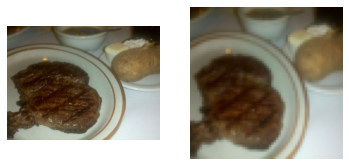

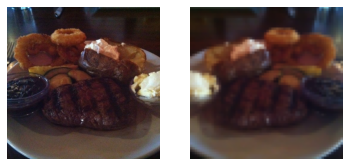

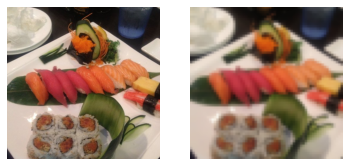

In [9]:
plot_image_transforms(image_path_list, data_transform)

### (1) Loading image data using ImageFolder

In [10]:
# create data loader using the image folder structure of the dataset
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform, target_transform=None)

print(train_data)
print(test_dir)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
data/pizza_steak_sushi/test


In [11]:
# print training class names list
print(train_data.classes)
# print training class names and indexes dictionary
print(train_data.class_to_idx)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [20]:
# first image, label pair
image, label = train_data[0]
print(image.shape) # [3, 64, 64]
# print torch.float32 image pixels
print(image)
# print int image label
print(label)

torch.Size([3, 64, 64])
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157, 

#### Create a data loader

In [23]:
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [24]:
print(f"Number of batches in train data loader: {len(train_loader)}")
print(f"Number of batches in test data loader: {len(test_loader)}")

Number of batches in train data loader: 225
Number of batches in test data loader: 75


In [25]:
# select the data of the next iterator returned from the data
image, label = next(iter(train_loader))
print(image.shape) # [1, 3, 64, 64]
print(label.shape) # [1]

torch.Size([1, 3, 64, 64])
torch.Size([1])


### (2) Loading image data using custom data set

In [30]:
import os # file navigation
import pathlib # file path management
import torch
from PIL import Image # Python Image Library
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, List, Dict # type hints for function prototypes

In [28]:
# get the class names of data set from the image file path
# create a sorted list of names of objects found in the training image file folder
file_class_names = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
# the way the image directories are structured means the directory objects are names of the classes
print(file_class_names)

['pizza', 'steak', 'sushi']


#### Create a list of class names from the image file directory structure

In [ ]:
# function returns a list of class names as well as dictionary of class labels and index
# implementation of .classes and .class_to_idx  attributes
def get_class_names(dir: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted([entry.name for entry in list(os.scandir(dir))])

  if not classes:
    # no class names found, throw error
    raise FileNotFoundError("Could not find classes within given directory")

  # dictionary of class names and associated indexes
  class_to_idx = {cls: i for i, cls in enumerate(classes)}

  return classes, class_to_idx

#### Create a custom dataset by subclassing torch.utils.data.Dataset

In [ ]:
# custom datasets must inherit from Datasets and override ___getitem__
class ImageDataset(Dataset):
  def __init__(self, target_dir: str, transform=None):
    super().__init__()

  def __len__(): # optional
    pass

  def __getitem__(): # required
    pass